## Human Activity Recognition

This notebook contains the code for processing the MotionSense dataset using AI and Machine Learning.

## 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

## 2. Dataset Loading and Sensor Column Setup

This code facilitates data loading. It reads CSV files using get_ds_infos() and set_data_types todefine the sensor columns.

In [2]:
# Step 1: Load Subject Information
def get_ds_infos():
    return pd.read_csv("./data/data_subjects_info.csv")

# Step 2: Define sensor columns
def set_data_types(data_types=["userAcceleration"]):
    dt_list = []
    for t in data_types:
        if t != "attitude":
            dt_list.append([t+".x",t+".y",t+".z"])
        else:
            dt_list.append([t+".roll", t+".pitch", t+".yaw"])
    return dt_list


## 3. Dataset Construction from Raw Files
create_time_series() combines sensor data (attitude, userAcceleration) and creates a time series.

In [3]:
# Step 3: Create Time-Series from raw data
def create_time_series(dt_list, act_labels, trial_codes, mode="mag", labeled=True):
    num_data_cols = len(dt_list) if mode == "mag" else len(dt_list*3)

    if labeled:
        dataset = np.zeros((0,num_data_cols+1)) # "1" --> [act] we do not need the other labels
    else:
        dataset = np.zeros((0,num_data_cols))
        
    ds_list = get_ds_infos()
    
    print("[INFO] -- Creating Time-Series")
    for sub_id in ds_list["code"]:
        for act_id, act in enumerate(act_labels):
            for trial in trial_codes[act_id]:
                fname = './data/A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                vals = np.zeros((len(raw_data), num_data_cols))
                for x_id, axes in enumerate(dt_list):
                    if mode == "mag":
                        vals[:,x_id] = (raw_data[axes]**2).sum(axis=1)**0.5        
                    else:
                        vals[:,x_id*3:(x_id+1)*3] = raw_data[axes].values
                    vals = vals[:,:num_data_cols]
                if labeled:
                    lbls = np.array([[act_id]]*len(raw_data))
                    vals = np.concatenate((vals, lbls), axis=1)
                dataset = np.append(dataset,vals, axis=0)
    cols = []
    for axes in dt_list:
        if mode == "raw":
            cols += axes
        else:
            cols += [str(axes[0][:-2])]
            
    if labeled:
        cols += ["act"]
    
    dataset = pd.DataFrame(data=dataset, columns=cols)
    return dataset

## 4. Activities
The following code defines activities and trials 

In [12]:
# Step 5:
ACT_LABELS = ["dws","ups", "wlk", "jog", "std", "sit"]
TRIAL_CODES = {
    ACT_LABELS[0]:[1,2,11],
    ACT_LABELS[1]:[3,4,12],
    ACT_LABELS[2]:[7,8,15],
    ACT_LABELS[3]:[9,16],
    ACT_LABELS[4]:[6,14],
    ACT_LABELS[5]:[5,13]
}

## Here we set parameter to build labeled time-series from dataset of "(A)DeviceMotion_data"
## attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
sdt = ["attitude", "userAcceleration"]
print("[INFO] -- Selected sensor data types: "+str(sdt))    
act_labels = ACT_LABELS [0:6]
print("[INFO] -- Selected activites: "+str(act_labels))    
trial_codes = [TRIAL_CODES[act] for act in act_labels]
dt_list = set_data_types(sdt)
dataset = create_time_series(dt_list, act_labels, trial_codes, mode="raw", labeled=True)
print("[INFO] -- Shape of time-Series dataset:"+str(dataset.shape))    
dataset.head()

[INFO] -- Selected sensor data types: ['attitude', 'userAcceleration']
[INFO] -- Selected activites: ['dws', 'ups', 'wlk', 'jog', 'std', 'sit']
[INFO] -- Creating Time-Series
[INFO] -- Shape of time-Series dataset:(1412865, 7)


,attitude.roll,attitude.pitch,attitude.yaw,userAcceleration.x,userAcceleration.y,userAcceleration.z,act
0,1.528132,-0.733896,0.696372,0.294894,-0.184493,0.377542,0.0
1,1.527992,-0.716987,0.677762,0.219405,0.035846,0.114866,0.0
2,1.527765,-0.706999,0.670951,0.010714,0.134701,-0.167808,0.0
3,1.516768,-0.704678,0.675735,-0.008389,0.136788,0.094958,0.0
4,1.493941,-0.703918,0.672994,0.199441,0.353996,-0.044299,0.0


# Data Pre-processing

## 6. Data Windowing

For each window (shape: `[window_size, n_axes]`), we compute:
- Time-domain: mean & standard deviation on each axis  
- Frequency-domain: spectral energy via FFT on each axis  
- Then normalize all features to zero mean & unit variance.

In [13]:
# Windowing function
def windows(dataset, window_size=100, stride=50):
    windows_list = []
    labels_list = []
    for act_id, group in dataset.groupby('act'):
        data = group.drop('act', axis=1).values
        for start in range(0, len(data) - window_size + 1, stride):
            end = start + window_size
            windows_list.append(data[start:end])
            labels_list.append(act_id)
    return np.stack(windows_list).astype(np.float32), np.array(labels_list).astype(np.int64)


Extract features from windows

In [14]:
# 6.2 Extract windows
X_windows, y_windows = windows(dataset, window_size=100, stride=50)

def extract_features_from_window(window: np.ndarray):
    """
    window: np.ndarray of shape (window_size, n_axes)
    returns: 1D feature vector [μ_axis1, σ_axis1, E_axis1, …]
    """
    feats = []
    # Time-domain
    feats.extend(window.mean(axis=0).tolist())   # mean per axis
    feats.extend(window.std(axis=0).tolist())    # std per axis

    # Frequency-domain
    fft_vals = np.fft.rfft(window, axis=0)       # real FFT per axis
    energy   = np.sum(np.abs(fft_vals)**2, axis=0)
    feats.extend(energy.tolist())                # spectral energy per axis

    return np.array(feats, dtype=np.float32)

# Build feature matrix shape (n_samples, n_features)
X_features = np.vstack([extract_features_from_window(w) for w in X_windows])

# Normalize features: zero mean, unit variance
scaler = StandardScaler()
X_features = scaler.fit_transform(X_features)

## 7. Train/Validation/Test Split

In [15]:
# Utility to split train/val/test
def train_val_test_split(X, y, test_size=0.2, val_size=0.1, random_state=None):
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    val_ratio = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, random_state=random_state, stratify=y_temp
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X_features, y_windows, test_size=0.2, val_size=0.1, random_state=42
)

# Wrap into TensorDatasets & DataLoaders
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_data   = TensorDataset(torch.tensor(X_val),   torch.tensor(y_val))
test_data  = TensorDataset(torch.tensor(X_test),  torch.tensor(y_test))

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_data,   batch_size=64, shuffle=False)
test_loader  = DataLoader(test_data,  batch_size=64, shuffle=False)

## 8. Models
Class definitions for the MLP Model

In [16]:
class SimpleMLP(nn.Module):
    def __init__(self, n_features, hidden_dim=128, num_classes=6):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_features, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, x):
        return self.net(x)


## 9. Training and Evaluation

Epoch 1/100 — Train Loss: 207.6727, Val Loss: 16.3384
Epoch 2/100 — Train Loss: 114.1665, Val Loss: 12.6659
Epoch 3/100 — Train Loss: 97.9897, Val Loss: 11.0623
Epoch 4/100 — Train Loss: 90.4411, Val Loss: 10.0925
Epoch 5/100 — Train Loss: 84.8254, Val Loss: 9.4774
Epoch 6/100 — Train Loss: 80.1161, Val Loss: 8.9095
Epoch 7/100 — Train Loss: 77.7376, Val Loss: 8.5436
Epoch 8/100 — Train Loss: 72.8274, Val Loss: 8.1285
Epoch 9/100 — Train Loss: 70.7595, Val Loss: 7.7621
Epoch 10/100 — Train Loss: 68.7957, Val Loss: 7.4941
Epoch 11/100 — Train Loss: 66.2532, Val Loss: 7.2091
Epoch 12/100 — Train Loss: 65.5492, Val Loss: 7.0328
Epoch 13/100 — Train Loss: 64.1068, Val Loss: 6.8376
Epoch 14/100 — Train Loss: 63.6313, Val Loss: 6.7704
Epoch 15/100 — Train Loss: 62.4144, Val Loss: 6.5904
Epoch 16/100 — Train Loss: 60.8869, Val Loss: 6.4902
Epoch 17/100 — Train Loss: 59.8924, Val Loss: 6.3274
Epoch 18/100 — Train Loss: 58.8840, Val Loss: 6.3499
Epoch 19/100 — Train Loss: 57.8477, Val Loss: 6.0

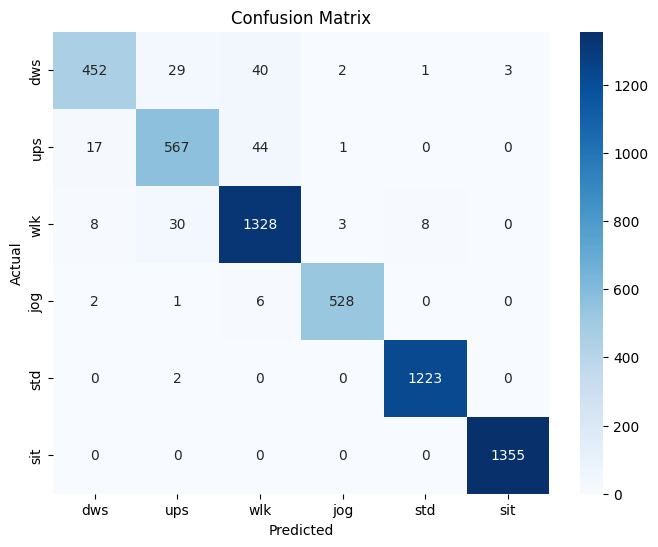

In [17]:
# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_features = X_features.shape[1]
model = SimpleMLP(n_features=n_features, hidden_dim=128, num_classes=len(act_labels)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs, patience = 100, 5
best_val_loss, counter = float('inf'), 0

for epoch in range(1, epochs+1):
    model.train()
    train_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        loss = criterion(model(Xb), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            val_loss += criterion(model(Xb), yb).item()

    print(f"Epoch {epoch}/{epochs} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss, counter = val_loss, 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping.")
            break

# 7.5 Test evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb = Xb.to(device)
        preds = model(Xb).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

print("Classification Report:\n", 
      classification_report(all_labels, all_preds, target_names=act_labels))
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("Precision:", precision_score(all_labels, all_preds, average='weighted'))
print("Recall:", recall_score(all_labels, all_preds, average='weighted'))
print("F1 Score:", f1_score(all_labels, all_preds, average='weighted'))

# Confusion matrix heatmap
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=act_labels, yticklabels=act_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
print(model)

SimpleMLP(
  (net): Sequential(
    (0): Linear(in_features=18, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=128, out_features=6, bias=True)
  )
)
